Based on statistical evaluation BIN exercise by Ing. Vojtěch Mrázek, Ph.D.

In [1]:
import pandas as pd
import re


In [2]:
def parse_filename(filename):
    g = re.match(r"logs(?:_standard)?/([^_]+)_(\d+)_(\d+)\.log", filename)
    circuit, pop, run = g.groups()
    return {
        "circuit": circuit,
        "pop": int(pop),
        "run": int(run)
    }


parse_filename("logs/adder2b_10_4.log")


{'circuit': 'adder2b', 'pop': 10, 'run': 4}

In [3]:
def parse_log(file, pop):
    for l in file.readlines():
        g = re.match(
        r"(\d+): (?:\([^\)]+\))*, (\d+)\/\d+( \(block cost \d+\/\d+\))?", l)
        if g and g.groups()[2]:
            break
    gen = None
    time = None
    if g:
        gen = int(g.groups()[0])
        time = gen * pop

    return {
        "gen": gen,
        "time": time,
        "fitness": int(g.groups()[1])
    }


print(parse_log(open("logs/parity5_5_0.log", "r"), 5))


{'gen': 5985, 'time': 29925, 'fitness': 32}


In [4]:
from os import listdir

def proc_file(filename):
    d = {"filename": filename}
    d = {**d, **parse_filename(filename)}
    with open(filename, "r") as f:
        d = {**d, **parse_log(f, pop=d["pop"])}
    return d

def proc_fold(fold):
    alld = []
    for filename in listdir(fold):
        alld.append(proc_file(fold + "/" + filename))
    df = pd.DataFrame(alld)
    idx = df.groupby(['circuit'])['fitness'].transform(max) == df['fitness']
    df = df[idx]
    idx = df.groupby(['circuit'])['time'].transform(min) == df['time']
    df = df[idx]
    best = pd.Series(df["filename"].values,index=df["circuit"]).to_dict()
    return best

best_xmg = proc_fold("logs")
best_standard = proc_fold("logs_standard")
print(best_xmg)
print(best_standard)

{'adder2b': 'logs/adder2b_15_7.log', 'median7': 'logs/median7_5_9.log', 'parity5': 'logs/parity5_5_5.log', 'mult2b': 'logs/mult2b_10_7.log'}
{'mult2b': 'logs_standard/mult2b_10_5.log', 'adder2b': 'logs_standard/adder2b_5_1.log', 'parity5': 'logs_standard/parity5_20_1.log', 'median7': 'logs_standard/median7_5_5.log'}


2b sčítač
./logs/adder2b_15_7.log
./logs_standard/adder2b_5_1.log
7x1b medián
./logs/median7_5_9.log
./logs_standard/median7_5_5.log
2b násobička
./logs/mult2b_10_7.log
./logs_standard/mult2b_10_5.log
5x1b parita
./logs/parity5_5_5.log
./logs_standard/parity5_20_1.log


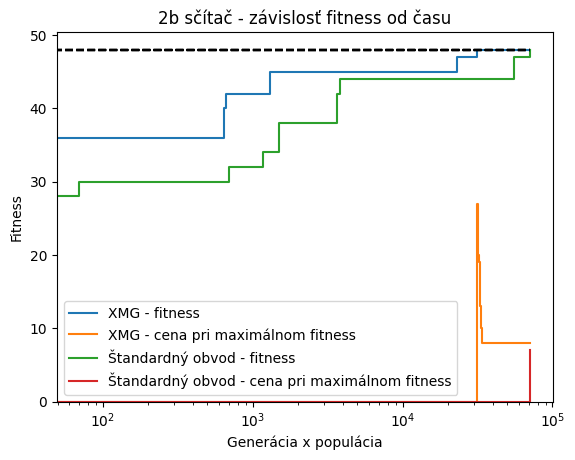

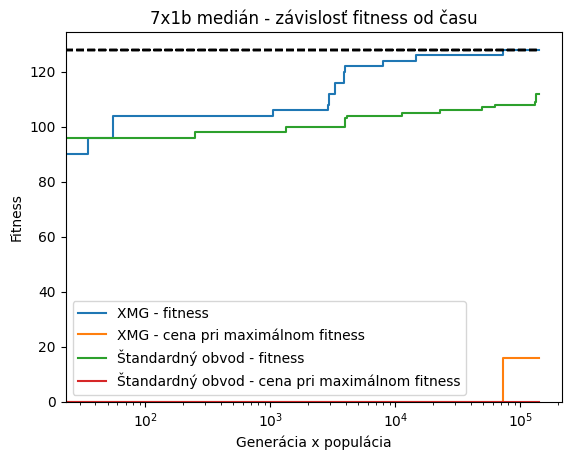

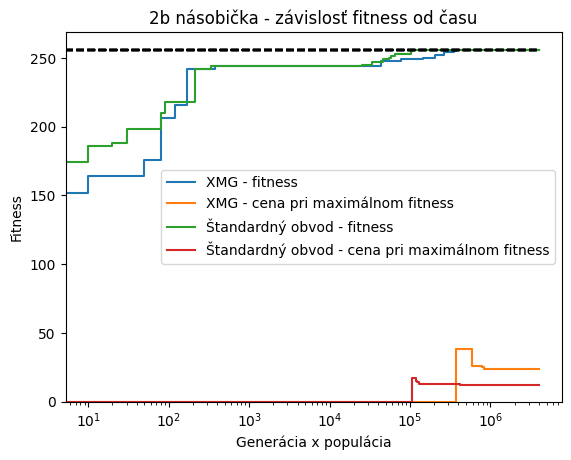

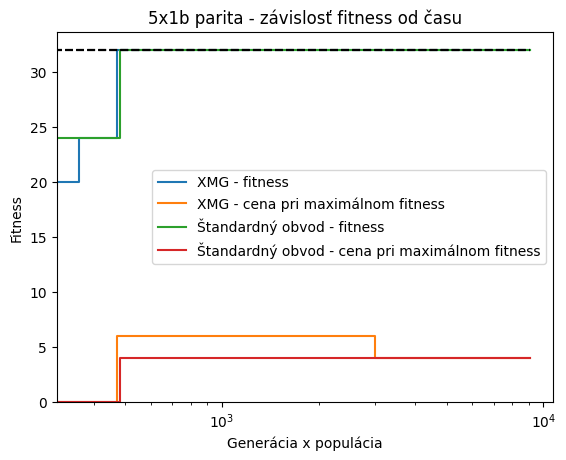

In [21]:
def proc_file(filename):
    with open(filename, "r") as f:
        data = []
        for l in f.readlines():
            g = re.match(
            r"(\d+): (?:\([^\)]+\))*, (\d+)\/(\d+)(?: \(block cost (\d+)\/\d+\))?", l)
            if g:
                gen = None
                time = None
                if g:
                    gen, fitness, max_fitness, block_cost = g.groups()
                    time = int(gen) * parse_filename(filename)["pop"]

                data.append({
                    "gen": int(gen),
                    "time": time,
                    "fitness": int(fitness),
                    "max_fitness": int(max_fitness),
                    "block_cost": int(block_cost) if block_cost else 0,
                })
        return pd.DataFrame(data)

import matplotlib.pyplot as plt

def add_ax(ax, df, label, max_time):
    time = df["time"].to_list() + [max_time]
    fitness = df["fitness"].to_list() + [df["fitness"].to_list()[-1]]
    cost = df["block_cost"].to_list() + [df["block_cost"].to_list()[-1]]
    ax.step(x = time, y = fitness, label = label + " - fitness")
    ax.step(x = time, y = cost, label = label + " - cena pri maximálnom fitness")

import os
if not os.path.exists("plot/"):
    os.makedirs("plot/")

for key, circuit in zip(sorted(best_xmg), ["2b sčítač", "7x1b medián", "2b násobička", "5x1b parita"]):
    fig, ax = plt.subplots()

    print(circuit)
    print("./" + best_xmg[key])
    print("./" + best_standard[key])

    df_xmg = proc_file(best_xmg[key])
    df_standard = proc_file(best_standard[key])
    max_time = max(df_standard["time"].max(), df_xmg["time"].max())

    add_ax(ax, df_xmg, "XMG", max_time)
    add_ax(ax, df_standard, "Štandardný obvod", max_time)

    ax.set(xscale="log", ylim=(0, None), xlabel="Generácia x populácia", ylabel="Fitness", title = circuit + " - závislosť fitness od času")
    ax.legend()
    ax.hlines(df_standard["max_fitness"], 0, max_time, color="black", linestyles="dashed", label="Maximálne fitness")
    fig.savefig("plot/" + key + ".pdf", format="pdf", dpi=300)

    